In [2]:
# libraries
import pickle
import numpy as np
import matplotlib.pyplot as plt
from itertools import product
from collections import defaultdict
from IPython.display import clear_output

In [3]:
f = open("training/hansards.36.2.e", "r", encoding="utf8") 
english_sentences = [ ['-NULL-'] + line.strip().lower().split() for line in f.readlines()]
f.close()
f = open("training/hansards.36.2.f", "r", encoding="utf8")
french_sentences = [line.strip().lower().split() for line in f.readlines()]
f.close()

In [4]:
translations = list(zip(english_sentences, french_sentences))
N = len(translations)
print(N)

231164


In [8]:
## this cell computes the RFEs (takes ~15 mins)

word_pair_counts = defaultdict(lambda: defaultdict(float))

# count the occurences of each french word given the english word
for t, (english, french) in enumerate(translations):
        
    # print percentage    
    clear_output(wait=True)
    print('{:0.0f}'.format(t/N*100), '%')
    
    # create list of possible alignments
    e_length = len(english)
    f_length = len(french)
    alignments = list(product(range(e_length), range(f_length)))
    
    # count word pair occurences
    for e_i, f_i in alignments:
        english_word = english[e_i]
        french_word = french[f_i]
        
        word_pair_counts[english_word][french_word] += 1

rfe = dict(word_pair_counts)

# compute the RFEs (divide the (f|e) word count by the total count of the (e) word)
for english_word, french_word_counts in rfe.items():
    total_occurences = sum(french_word_counts.values())
    for french_word in rfe[english_word]:
        word_count = rfe[english_word][french_word]
        rfe[english_word][french_word] = word_count / total_occurences
        
# save to pickle
pickle.dump(rfe, open('pickles/rfe.pkl', 'wb'))

100 %


In [9]:
# quick check if everything sums (approx) to 1
rfe = pickle.load(open('pickles/rfe.pkl', 'rb'))

not_one = []
for _, probs in rfe.items():
    prob_sum = sum(probs.values())
    if prob_sum != 1.0:
        not_one.append(prob_sum)
not_one = np.array(not_one)
print(len(not_one[not_one < 0.99999999999]) == 0)

True


# IBM1 EM Algorithm

In [7]:
def alignment_indices(english_sentence, french_sentence):
    e_length = len(english_sentence)
    f_length = len(french_sentence)
    alignments = list(product(range(e_length), range(f_length)))
    return alignments

In [26]:
def compute_perplexity(theta_dict, aligned_sentences):
    logprobs = []
    total_sum = 0
    for english_sentence, french_sentence in aligned_sentences:
        french_sum = 0
        for j in range(len(french_sentence)): 
            f_j = french_sentence[j]
            log_sum = []
            for i in range(len(english_sentence)): 
                e_i = english_sentence[i]
                log_sum.append(theta_dict[f_j][e_i])
            french_sum += np.log(np.sum(log_sum))
        total_sum += french_sum
    perplexity = total_sum
    return perplexity

In [33]:
iterations = 10
sub = 500

french_vocab = list(set([word for sublist in french_sentences[:sub] for word in sublist]))
english_vocab = list(set([word for sublist in english_sentences[:sub] for word in sublist]))

# initialize theta_0 uniformly
theta_0 = 1 / len(english_vocab)

theta_dict = defaultdict(lambda: defaultdict(lambda:theta_0))

perplexities = []

for t in range(iterations):
    print('iteration', t)
    # initialize all counts to 0
    counts_dict = defaultdict(lambda: defaultdict(lambda: 0.))
    total_f_dict = defaultdict(lambda: 0.)
    total_e_dict = defaultdict(lambda: 0.)
    
    # E-step
    for english, french in translations[:sub]:
        for french_word in french:
            total_f_dict[french_word] = 0.
            for english_word in english:
                total_f_dict[french_word] += theta_dict[french_word][english_word]
        for french_word in french:
            for english_word in english:
                value = theta_dict[french_word][english_word] / total_f_dict[french_word]
                counts_dict[french_word][english_word] += value
                total_e_dict[english_word] += value
    
    # M-step
    for english_word in english_vocab:
        for french_word in french_vocab:
            theta_dict[french_word][english_word] = \
            counts_dict[french_word][english_word] / total_e_dict[english_word]
            
    # compute perplexity
    perplexity = compute_perplexity(theta_dict, translations[:sub])
    perplexities.append(perplexity)

iteration 0
iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9


In [35]:
import operator

theta_dict['le']
prediction = max(theta_dict['le'].items(), key=operator.itemgetter(1))[0]

print(theta_dict['le']['new'], theta_dict['le']['the'])
print(prediction)

0.14599636103845678 0.4485129388732313
right


[-9207.006069019868, -5692.918560808974, -4053.160591950937, -3186.703303400729, -2690.2344980918124, -2388.4188395541164, -2195.7115419160614, -2067.27210526488, -1978.3501351366247, -1914.6856984306319]


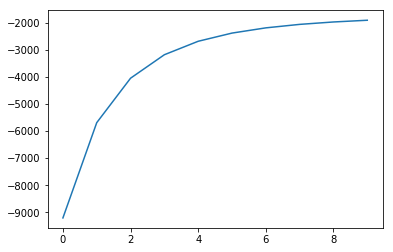

In [34]:
print(perplexities)
plt.plot(perplexities)
plt.show()

# IBM1 Variational Inference

# IBM2

In [5]:
max_l = max([len(s) for s in english_sentences])
max_m = max([len(s) for s in french_sentences])

In [61]:
iterations = 10
sub = 10000

theta_dict = defaultdict(lambda: defaultdict(lambda: 0.1))
q = defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: 0.1))))
perps = []

for s in range(iterations):
    
    print('iteration', s)
    # initialize all counts to 0
    
    counts_words_dict = defaultdict(lambda: defaultdict(lambda: 0.))
    counts_alignments_dict = defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: 0.))))
    count_f_dict = defaultdict(lambda: 0.)
    count_e_dict = defaultdict(lambda: 0.)
    
    for english_sentence, french_sentence in translations[:sub]:
        l = len(english_sentence)
        m = len(french_sentence)
        for i in range(m):
            f_i = french_sentence[i]
            delta_denominator = sum([q[j_k][i][l][m]*theta_dict[f_i][english_sentence[j_k]] for j_k in range(l)])
            
            for j in range(l):
                e_j = english_sentence[j]
                
                delta = (q[j][i][l][m]*theta_dict[f_i][e_j]) / delta_denominator
                
                counts_words_dict[e_j][f_i] += delta
                count_e_dict[e_j] += delta
                counts_alignments_dict[l][m][i][j] += delta
                
#     for english_sentence, french_sentence in translations[:sub]:
#         l = len(english_sentence)
#         m = len(french_sentence)
#         for i in range(m):
#             for j in range(l):
#                 f_i = french_sentence[i]
#                 e_j = english_sentence[j]
                
#                 q[j][i][l][m] = counts_alignments_dict[l][m][i][j] / sum(counts_alignments_dict[l][m][i].values())
#                 theta_dict[f_i][e_j] = counts_words_dict[e_j][f_i] / count_e_dict[e_j]
                
    for j in q.keys():
        for i in q[j].keys():
            for l in q[j][i].keys():
                for m in q[j][i][l].keys():
                    q[j][i][l][m] = counts_alignments_dict[l][m][i][j] / sum(counts_alignments_dict[l][m][i].values())
    
    for f_i in theta_dict.keys():
        for e_j in theta_dict[f_i].keys():
            theta_dict[f_i][e_j] = counts_words_dict[e_j][f_i] / count_e_dict[e_j]
                
    perp = compute_perplexity(theta_dict, translations[:sub])
    perps.append(perp)

iteration 0
iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9


KeyboardInterrupt: 

In [ ]:
# perplexity plot IBM2
print(perps)
plt.figure()
plt.plot(perps)
plt.show()

In [58]:
# sanity check
probs_for_the = sum([theta_dict[x]['the'] for x in theta_dict.keys() if 'the' in theta_dict[x].keys()])
print('sum of probs for \'the\':', probs_for_the)

translation_the = max([(x, theta_dict[x]['the']) for x in theta_dict.keys() if 'the' in theta_dict[x].keys()],
                     key=lambda x: x[1])[0]
print('predicted translation of \'the\':', (translation_the, theta_dict[translation_the]['the']))

print('')

probs_for_le = sum(theta_dict['le'].values())
print('sum of probs for \'le\':', probs_for_le)

translation_le = max(theta_dict['le'].items(), key=lambda x: x[1])[0]
print('predicted translation of \'le\':', (translation_le, theta_dict['le'][translation_le]))

sum of probs for 'the': 1.0000000000000104
predicted translation of 'the': ('le', 0.4485129388732313)

sum of probs for 'le': 20.682416749785386
predicted translation of 'le': ('right', 0.7126416713783849)
